# ProfLogit for Customer Churn Prediction

In [1]:
import numpy as np
from proflogit import ProfLogit
from proflogit.utils import load_data

## Basic usage

### Load some data

Have a look at the raw data.

In [2]:
!head ../data/patsy_demo_train.dat

"y" "c" "x"
1 "c1" 1.764052345967664
0 "c3" 0.9787379841057392
0 "c2" 1.8675579901499675
0 "c1" 0.9500884175255894
1 "c3" -0.10321885179355784
1 "c2" 0.144043571160878
0 "c1" 0.7610377251469934
0 "c3" 0.44386323274542566
0 "c2" 1.4940790731576061


In [3]:
X_train, y_train = load_data('../data/patsy_demo_train.dat', target_variable='y')

Your data should be stored in a dict-like object that allows accessing the variables via `data[varname]`.

In [4]:
print(type(X_train))
for varname, var in X_train.items():
    print(varname, type(var), var[:5])

<class 'dict'>
c <class 'list'> ['"c1"', '"c3"', '"c2"', '"c1"', '"c3"']
x <class 'numpy.ndarray'> [ 1.76405235  0.97873798  1.86755799  0.95008842 -0.10321885]


Here, `c` is nominal and `x` is numeric.
The ``load_data`` function returns a ``dict`` in which data of numeric variables are stored in a `numpy.ndarray`.
For all others, data are stored in a `list`.

Check target variable, where ``1`` represents *cases*.

In [5]:
print(type(y_train), y_train[:10])

<class 'numpy.ndarray'> [1 0 0 0 1 1 0 0 0 1]


### Build a ProfLogit model

In [6]:
pfl = ProfLogit(
    rga_kws={
        'niter': 10,
        'disp': True,
        'random_state': 42,
    },
).fit(X_train, y_train)

# ---  RGA (Fri Jan 19 17:09:42)  --- #
Iter =     0; nfev =     40; fx = 14.8297
Iter =     1; nfev =     73; fx = 14.8597
Iter =     2; nfev =    106; fx = 14.8836
Iter =     3; nfev =    143; fx = 15.0351
Iter =     4; nfev =    173; fx = 15.0351
Iter =     5; nfev =    206; fx = 15.0631
Iter =     6; nfev =    239; fx = 15.0631
Iter =     7; nfev =    272; fx = 15.0700
Iter =     8; nfev =    301; fx = 15.0700
Iter =     9; nfev =    334; fx = 15.0814
Iter =    10; nfev =    370; fx = 15.0894
      fun: 15.089449928999562
  message: 'Maximum number of iterations has been reached.'
     nfev: 370
      nit: 10
 nit_diff: 0
  success: True
        x: array([ 0.43488295, -0.22545574,  0.        ,  0.45229042])
# ---  RGA (Fri Jan 19 17:09:43)  --- #


The optimization result is stored in the attribute ``res`` of ProfLogit's RGA instance.
For example, the best solution found can be accessed as follows:

In [7]:
pfl.rga.res.x

array([ 0.43488295, -0.22545574,  0.        ,  0.45229042])

ProfLogit makes use of `patsy` to easily create design matrices.
That is, it uses the `patsy.dmatrix` function which *only* requires the *right-hand* side.
When no formula is provided via ProfLogit's argument ``formula_like``,
it, by default, models *only main effects*, where numeric variables are standardized.
When the ``fit`` method is called, the formula used to create the design matrix 
is populated with the names taken from the dict-like input data.

ProfLogit's attribute ``formula`` shows what formula has been used to construct the design matrix.

In [8]:
pfl.formula

'c + standardize(x)'

### Plot search path

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
best_so_far_solutions = pfl.rga.fx_best
print(type(best_so_far_solutions), best_so_far_solutions[:3])

<class 'list'> [14.829698953657063, 14.859698953657063, 14.883592364032996]


*Note*: The first value in the list above is the best fitness value of the zero generation (i.e., at the time of initialization).

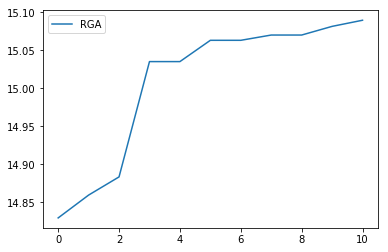

In [11]:
plt.plot(best_so_far_solutions, label='RGA')
plt.legend();

### Make predictions

In [12]:
!head ../data/patsy_demo_test.dat

"y" "c" "x"
1 "c1" 1.764052345967664
1 "c2" -0.2127402802139687
1 "c3" 0.7774903558319101
1 "c1" -0.4380743016111864
0 "c2" 1.9507753952317897
1 "c3" -1.4200179371789752
0 "c1" -0.30230275057533557
0 "c2" 1.2023798487844113
1 "c3" 0.15634896910398005


In [13]:
X_test, y_test = load_data('../data/patsy_demo_test.dat', target_variable='y')

Compute the probability that an instance is a case.
Here, a case corresponds to a *churner*.

*Note*: By default, numeric variables are scaled through patsy's built-in standardization transformation function.
When such a transformation is in place, new data are scaled appropriately before scoring with the scaling parameters obtained from the training data.

In [14]:
y_score = pfl.predict_proba(X_test)

In [15]:
print(type(y_score), y_score[:3])

<class 'numpy.ndarray'> [ 0.74010046  0.51971389  0.66286996]


### Compute EMPC performance on test set

In [16]:
empc0 = pfl.score(X_test, y_test)
empc0

25.503582714628958

# Using Pandas

In [17]:
import pandas as pd

### Load some data

In [18]:
df_train = pd.read_csv('../data/patsy_demo_train.dat', sep=' ')

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 3 columns):
y    26 non-null int64
c    26 non-null object
x    26 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 704.0+ bytes


In [20]:
df_train.head()

,y,c,x
0,1,c1,1.764052
1,0,c3,0.978738
2,0,c2,1.867558
3,0,c1,0.950088
4,1,c3,-0.103219


In [21]:
X_train = df_train.loc[:, ['c', 'x']]
y_train = df_train.loc[:, 'y']

In [22]:
print(type(y_train))
print(y_train[:10])

<class 'pandas.core.series.Series'>
0    1
1    0
2    0
3    0
4    1
5    1
6    0
7    0
8    0
9    1
Name: y, dtype: int64


### Build a ProfLogit model

In [23]:
pfl_pd = ProfLogit(
    rga_kws={
        'niter': 10,
        'disp': True,
        'random_state': 42,
    },
)
pfl_pd.fit(X_train, y_train);

# ---  RGA (Fri Jan 19 17:09:44)  --- #
Iter =     0; nfev =     40; fx = 14.8297
Iter =     1; nfev =     73; fx = 14.8597
Iter =     2; nfev =    106; fx = 14.8836
Iter =     3; nfev =    143; fx = 15.0351
Iter =     4; nfev =    173; fx = 15.0351
Iter =     5; nfev =    206; fx = 15.0631
Iter =     6; nfev =    239; fx = 15.0631
Iter =     7; nfev =    272; fx = 15.0700
Iter =     8; nfev =    301; fx = 15.0700
Iter =     9; nfev =    334; fx = 15.0814
Iter =    10; nfev =    370; fx = 15.0894
      fun: 15.089449928999562
  message: 'Maximum number of iterations has been reached.'
     nfev: 370
      nit: 10
 nit_diff: 0
  success: True
        x: array([ 0.43488295, -0.22545574,  0.        ,  0.45229042])
# ---  RGA (Fri Jan 19 17:09:44)  --- #


It uses the same formula as in the previous example.

In [24]:
pfl_pd.formula

'c + standardize(x)'

### Plot search path

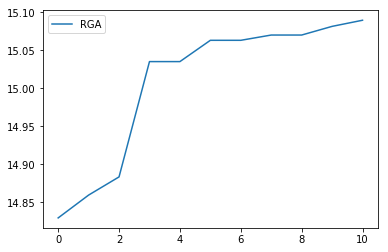

In [25]:
best_so_far_solutions = pfl_pd.rga.fx_best
plt.plot(best_so_far_solutions, label='RGA')
plt.legend();

### Make predictions

In [26]:
df_test = pd.read_csv('../data/patsy_demo_test.dat', sep=' ')

In [27]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 3 columns):
y    26 non-null int64
c    26 non-null object
x    26 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 704.0+ bytes


In [28]:
df_test.head()

,y,c,x
0,1,c1,1.764052
1,1,c2,-0.212740
2,1,c3,0.777490
3,1,c1,-0.438074
4,0,c2,1.950775


In [29]:
X_test = df_test.loc[:, ['c', 'x']]
y_test = df_test.loc[:, 'y']

In [30]:
y_score = pfl_pd.predict_proba(X_test)

In [31]:
print(type(y_score), y_score[:3])

<class 'numpy.ndarray'> [ 0.74010046  0.51971389  0.66286996]


### Compute EMPC performance on test set

In [32]:
empc1 = pfl_pd.score(X_test, y_test)
empc1

25.503582714628958

Check if we get the same EMPC performance on the test set.

In [33]:
from math import isclose
isclose(empc0, empc1)

True